# Reinforcement learning introduction
Tutorial prepared by Borja Requena and Gorka Muñoz-Gil for the Summer School in Machine Learning for Quantum Physics and Chemistry (Warsaw 2021).

With this hands-on session, we aim to provide a better understanding of reinforcement learning. We will start with Q-learning, as seen in the lectures of Florian Marquardt, using a Q-table and a Q-network. We will implement and test the algorithms to beat the [Frozen Lake](https://gym.openai.com/envs/FrozenLake-v0/) game provided by the [OpenAI gym](https://gym.openai.com/). 

## The environment: Openai gym

As we have seen in the lessons, the main elements of reinforcement learning are an agent that interacts with an environment. The agent will be defined by our algorithm of choice, but the environment will always be the same throughout the notebook. 

As previously mentioned, we will be using the [OpenAI gym](https://gym.openai.com/) to train our agents. More precisely, we will beat the [Frozen Lake](https://gym.openai.com/envs/FrozenLake-v0/) game. This game consists of a grid that represents a frozen lake with holes. The frozen tiles are safe, but the wholes will lead to our agent's terrible death from hypothermia (bad, bad!). The agent can move in four directions: left, down, right and up, with the goal of reaching a frisbee in a target position without falling into the water, but beware the slippery ice! Walking on ice is tricky and the agent, while trying to move in a given direction, may slip and slide to a different position.  

Let's have a look at the environment!

In [1]:
!pip install gymnasium

/bin/bash: /home/gorka/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
  Using cached cloudpickle-3.1.1-py3-none-any.whl.metadata (7.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 kB 11.0 MB/s eta 0:00:00
Using cached cloudpickle-3.1.1-py3-none-any.whl (20 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 11.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [gymnasium]/4 [gymnasium]


In [1]:
import gymnasium as gym

In [ ]:
env = gym.make('FrozenLake-v1', render_mode="ansi")

env.reset()
print(env.render())


SFFF
FHFH
FFFH
HFFG



To understand the previous figure:

*S: starting point, safe; F: frozen surface, safe; H: hole, fall to your doom; G: goal, where the frisbee is located; red square shows the agent's current position*. However, the previous figure may be a bit misleading, as the environment is represented by a matrix that is transposed with respect to the representation. 

In order to get an idea of how to interact with the environment, let's do a simple random walk. We will start importing the required libraries and defining some support functions:

In [9]:
# The content of this cell does not need to be fully understood. 

import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from tqdm.auto import tqdm
%matplotlib inline

font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 21,
        }

# This function will help us get nice plots
def plot_matrix(one_hot):
    ''' Reshapes one_hot vector to 4x4 matrix and plots results'''
    matt = np.zeros([4,4])
    for x in range(4):
        for y in range(4):      
            matt[x,y] = one_hot[x+4*y]

    plt.figure()
    plt.xticks([0.5,1.5,2.5,3.5], ('0','1','2','3'))
    plt.yticks([0.5,1.5,2.5,3.5], ('0','1','2','3'))

    plt.text(3, 3, "G", size=20, rotation=0,
            ha="center", va="center",
            bbox=dict(boxstyle="square",
                    ec=(1.,0, 0),
                    fc=(0, 0.82, 1),
                    )
            )
    plt.text(0, 0, "S", size=20, rotation=0,
            ha="center", va="center",
            bbox=dict(boxstyle="square",
                    ec=(0.8, 0.82, 0),
                    fc=(0.8, 0.82, 0),
                    )
            )  
    plt.imshow(matt, cmap='Greys')

    return matt

Let's now proceed with the random walk. With this walk, we will search for the rewards and holes in the environment and build a simple reconstruction, just like a cartographer. This is mainly to get a feeling of how to interact with the environment.

In [ ]:
env_size = env.observation_space.n # 4x4 grid -> 16
env_reconstruction = np.zeros(env_size)
found_rewards = np.zeros(env_size)
n_games = 200
max_t = 99

for i in range(n_games):
    # Reset environment and get first new observation
    s = env.reset()
    done = False
    for j in range(max_t):        
        # Choose an random action
        a = np.argmax(np.random.randn(1,env.action_space.n))
        
        # Make the environment do a step given the action a        
        s1, r, done, _, _ = env.step(a) # position, reward, terminated, truncated, probability
        
        # Let's store the reward receive for each state s1
        # We scale it by 3 to distinguish it at the end
        found_rewards[s1] = 3*r
        
        # Done (if True) indicates the end of a game: fall or win
        if done == False:
            env_reconstruction[s1] = 1 # Mark safe spots
              
        s = s1
        if done == True:
            break

In [ ]:
env.step(a)[-1]

{'prob': 0.3333333333333333}

Now that we have explored the environment, let's plot our findings.

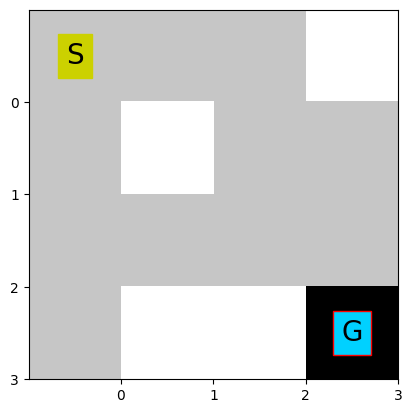

In [ ]:
sys_mat = plot_matrix(env_reconstruction+found_rewards)

White squares indicate holes (bad), grey are frozen squares (good) and in black we have the goal. The walk starts at $(0, 0)$. As you can see, this figure is indeed a transposed version of the `env.render()` result (see below).

In [ ]:
print(env.render())

  (Up)
SFFF
FHFH
FFFH
HFFG



## Q-table algorithm

Our first approach to Q-learning will be to implement it in the form of a Q-table. In order to implement this algorithm, we store the estimated Q-values $Q(s, a)$ in a table (hence the name) of size *# states $\times$ # possible actions*. In the case of the Frozen Lake, there are $4\times 4$ possible states and $4$ possible actions, hence the table will be of size $16\times 4$. 

Each entry of the Q-table is updated as the agent explores the environment and collects rewards by means of the Bellman equation:

$$Q^{new}(s_{t},a_{t}) \leftarrow (1-\alpha) \cdot \underbrace{Q(s_{t},a_{t})}_{\text{old value}} + \underbrace{\alpha}_{\text{learning rate}} \cdot  \overbrace{\bigg( \underbrace{r_{t}}_{\text{reward}} + \underbrace{\gamma}_{\text{discount factor}} \cdot \underbrace{\max_{a}Q(s_{t+1}, a)}_{\text{estimate of optimal future value}} \bigg) }^{\text{learned value}} $$

The algorithm works as follows:

In [ ]:
env.reset()[0]

0

In [ ]:
def train_q_table(env, num_episodes, alpha, gamma, max_t=99):
    """Q-table algorithm implementation."""
    # Initialize Q table
    Q = np.zeros([env.observation_space.n, env.action_space.n])
    # Instantiate a couple of lists to keep track of progress
    time_steps = []
    rewards = []
  
    for i in range(num_episodes):
        # Reset environment and initialize all variables
        s = env.reset()[0]
        r = 0
        done = False
        # The Q-Table learning algorithm
        for j in range(max_t):
            # Choose an action greedily (with noise) picking from Q table.
            # We can alternatively use an epsilon-greedy policy
            a = np.argmax(Q[s,:] + np.random.randn(1, env.action_space.n)*(1./(i+1)))
            #Get new state and reward from environment
            s1, r, done, _, _ = env.step(a)
            #Update Q-Table with new knowledge
            Q[s,a] = Q[s,a] + alpha*(r + gamma*np.max(Q[s1,:]) - Q[s,a])

            s = s1
            if done == True:
                break
        
        time_steps.append(j + 1)
        rewards.append(r)
      
    return Q, time_steps, rewards

We can test the algorithm setting some parameters. Let's see how it goes:

In [ ]:
# Set learning rate and discount factor parameters
alpha = 0.8
gamma = 0.9

# Runs of the algorithm and episodes of each run
runs = 50
num_episodes = 2000

steps, rewards, Qs = [], [], []
for _ in tqdm(range(runs)):
    Q, time_steps, obtained_rewards = train_q_table(env, num_episodes, alpha, gamma)

    Qs.append(Q)
    steps.append(time_steps)
    rewards.append(obtained_rewards)

100%|██████████| 50/50 [00:39<00:00,  1.26it/s]


Let us compute the average reward and number steps per episode

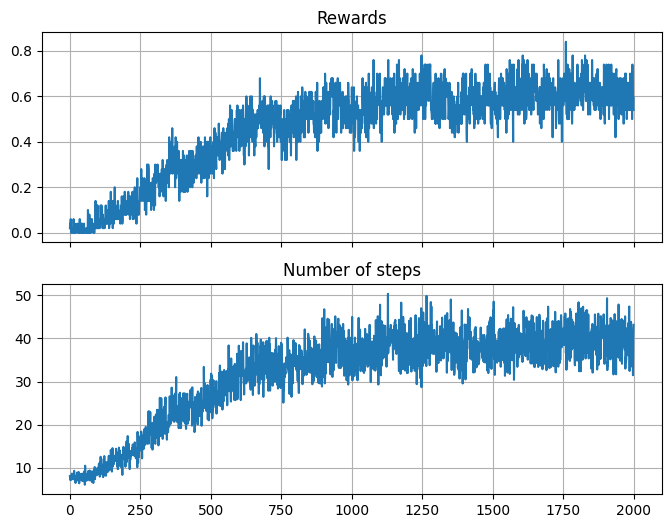

In [ ]:
avg_steps = np.mean(steps, 0)
avg_rewards = np.mean(rewards, 0)

f, axes = plt.subplots(2, sharex=True, figsize=(8, 6))
axes[0].plot(avg_rewards)
axes[0].grid()
axes[0].set_title('Rewards')
axes[1].plot(avg_steps)
axes[1].grid()
axes[1].set_title('Number of steps');

Let us explore a bit the resulting Q-tables. We will create a sort of value function $V(s)$ to see which states, on average, are more valuable. 

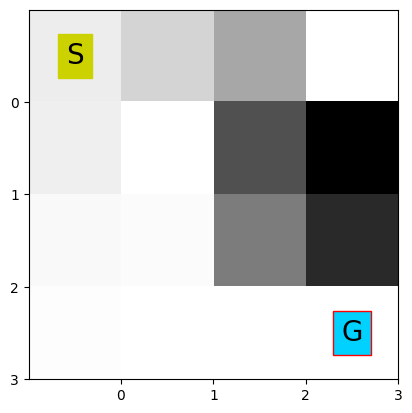

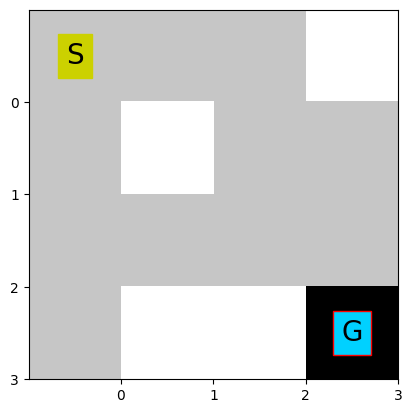

In [ ]:
mean_Q = np.mean(Qs, 0) # Average over all runs 
V = [np.max(q) for q in mean_Q]
plot_matrix(V)
plot_matrix(env_reconstruction+found_rewards);

We can see that, on average, the points that are closer to the goal state have a higher value, so long as the goal is reachable from there. We encourage you to try plotting the Q-table found by different agents and see whether there are notable differences.  

Then, try to repeat the same training with different values of $\gamma$, which has been set to `gamma = 0.9`. Larger discount factors, e.g. $\gamma=0.99$, will propagate the value of the goal state further. Conversely, lower discount factors, e.g. $\gamma=0.7$, will result into much lower Q-values at the beginning of the trajectories. Try and see! :)

## Q-Network

So far, we have implemented Q-learning using a $16\times 4$ Q-table. However, this approach suffers from serious scalability issues. We have used a very small system with very few states and actions, but what happens when we work with much complex systems, where the number of possible states and actions is too big to be stored in a matrix? This also applys to continuous systems, where the number of states is virtually infinite. 

In these cases, we have to find an efficient encoding of the Q-values. The go to solution in these cases is to use a neural network. This way, instead of keeping a table with all the Q-values, we will train a network to predict the rows of the table. Hence, the network takes a state as input and outputs the Q-values associated to all the possible actions that can be done in the given state.  

So let's start by constructing our first little Q-network! 

> For this part, you need to install tensorflow (see https://www.tensorflow.org/install/pip?hl=es). This code was implemented for an older version of Tensorflow, but is still running in the newer versions, although not efficiently.

In [ ]:
from tensorflow import keras
from tensorflow.keras.layers import Dense

def make_q_network(input_size, output_size, hidden_size=24):
    "Create a dense network with desired shape"
    q_network = keras.Sequential([
                Dense(hidden_size, input_dim=input_size, activation='relu'),
                Dense(hidden_size, activation='relu'),
                Dense(output_size, activation='linear')
                ])
    
    q_network.compile(optimizer='adam',
              loss='mse')
    
    return q_network

As it was shown in the reinforcement learning lessons, it is more efficient to train by batches than with single samples. In order to build these, we will provide our agent with a *memory* where it will store every step of the Markov decision process $(s, a, r, s')$. 

Then, instead of updating the parameters of the network after every episode of the game, the agent will gather experience through several episodes and, then, it will *replay* these episodes in its memory to do the learning. You can think of it as if the agent explored the world during the day and then learned from its observations by reflecting in bed before sleeping. Furthermore, during the replay, we will take the samples $(s, a, r, s')$ at random to guarantee that they are not correlated.

Let's start by creating a `QNAgent` class and provide it with a way to memorize its actions and their outcomes. 

In [ ]:
class QNAgent:
    def memorize(self, state, action, reward, next_state, done):
        "Memorize the outcome of an action (s, a, r, s', done)"
        self.memory.append((state, action, reward, next_state, done))

Replaying is the crucial part of our agent, as it is where the training of network occurs. The loss function is as follows:

$$loss=(\underbrace{r_t+\gamma \max_{a'}Q(s_{t+1},a_{t+1}')}_{target}-\underbrace{Q(s_t,a_t)}_{prediction})$$

In [ ]:
import random
class QNAgent(QNAgent):  
    def replay(self, batch_size):
        """Replay the memories of past games. This function trains with a 
        sample at a time. Implement batch training as homework."""
        # We create a batch of states by randomly sampling the memory
        batch = random.sample(self.memory, batch_size)
        state, action, reward, next_state, done = np.hsplit(np.array(batch, dtype=object), 5)
        
        # Fix some shapes to fit into the neural network 
        state = np.concatenate(np.concatenate(state), axis=0).reshape(batch_size, -1)
        next_state = np.concatenate(np.concatenate(next_state), axis=0).reshape(batch_size, -1)

        # Let's replay!
        # We start by constructing the target part of the loss:
        # First, predict the Q values of the next states
        next_state_preds = self.model.predict(next_state.astype(float))
        # Then, add the reward to the Q values of those states that were not "done"
        q_value_target = reward + (~done.astype(bool)*np.amax(next_state_preds, axis=1)[:, None])

        # In order to make it easier to build the loss, we ask the model to predict the Q values
        # and then we assign to each performed action the target q value. This effectively
        # implements the loss function: loss for the given action and 0 difference for the rest.
        target = self.model.predict(state.astype(float))
        target[np.arange(batch_size), action.astype(int).squeeze()] = q_value_target.squeeze()
            
        # Then, we train the model
        self.model.fit(state.astype(float), target, epochs=1, verbose=0) 
            
        # Finally, we decrease the value of the greedy election    
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

As last step, we need to provide the agent with the capability of acting! We're generous gods.

We implement an $\varepsilon$-greedy policy, meaning that we perform greedy actions according to the Q-values and a random action with probability $\varepsilon$. This way, we force the agent to always keep exploring and we can find an exploration-exploitation balance tunning the $\varepsilon$. Furthermore, we will start with a high $\varepsilon$ to encourage early exploration and decrease it during training so that the agent can exploit what it has learned. 

In [ ]:
class QNAgent(QNAgent):
    def act(self, state):
        "Take actions according to an epsilon-greedy policy"
        # The agent has the capability of doing a greedy action
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        
        # Or an action taken from the model
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])    

Finally, let's set the parameters of the learning procedure.

In [ ]:
from collections import deque
class QNAgent(QNAgent):
    def __init__(self, q_network, n_actions):
        self.model = q_network
        self.action_size = n_actions
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0   # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001

Let's now create the Q-network algorithm:

In [ ]:
def train_q_network(env, agent, num_episodes, batch_size, state_size, max_t=99):
    "Train a Q-network based agent in the environment."
    steps, rewards, states = [], [], []
  
    for _ in tqdm(range(num_episodes)):
        # Reset the environment for each new episode
        state = env.reset()[0]
        state = np.reshape(state, [1, state_size])
        done = False
        
        for j in range(max_t):
        # The Q-Network learning algorithm
            action = agent.act(state)
            next_state, reward, done, _, _ = env.step(action) 
            next_state = np.reshape(next_state, [1, state_size])
            agent.memorize(state, action, reward, next_state, done)
            state = next_state    

            if done:
                steps.append(j + 1)
                break

        rewards.append(reward)
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)
    
    return rewards, steps

In [ ]:
# Parameters of the environment
env = gym.make('FrozenLake-v1')
runs = 2 # Watch out! It takes a while, prototype with only one run
num_episodes = 1000

# Parameters for the agent
action_size = env.action_space.n
batch_size = 64

# Initialize the Q network
state_size = 1
q_network = make_q_network(state_size, action_size)

# We will run the progam runs times to average over many played games
rewards_per_run = []
steps_per_run = []
for run in range(runs):
  
    agent = QNAgent(q_network, action_size)
    rewards, steps = train_q_network(env, agent, num_episodes, batch_size, state_size)

    rewards_per_run.append(rewards)
    steps_per_run.append(steps)

Did it work? Let's compare it in the first 500 episodes with one of the Q-tables

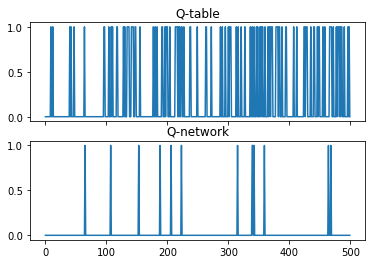

In [ ]:
f, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(rewards[0][:500])
axarr[0].set_title('Q-table')
axarr[1].plot(rewards_per_run[0][:500])
axarr[1].set_title('Q-network');

As you can see, it is much worse! Why?

We see that it is much worse in terms of average reward and that it takes much longer than the Q-table to train. The fact is that it is much better to use Q-table whenever our problem allows for it and there is little structure in the state-space. Q-networks are harder to train and require a bit more engineering. However, they excel at dealing with large state spaces that would be impossible to fit into a Q-table. For instance, it would be impossible to play any atari game using a Q-table, but they are no match for Q-networks! 

# Homeworks

a) Create an agent that is able to win in the Frozen Lake game, but with the optimal path. This means, the path with the smallest number of steps. Compare the results when training the Q-table and the Q-network. Explain why one is better than the other.

b) Use the Q-network to train an agent on the Cart-Pole game. See details on this environment below.

## Finding the shortest path

A very simple way to train a model to find the shortest possible path is to penalize it for every step it takes. We can do so by introducing a cost for the movement (negative reward) that will encourage the agent to find the shortest path towards the goal. 

Usually, when we have competing terms in our reward function we weight them and tune a free parameter $R_t = r_t - \lambda c_t$ where $r_t$ is the reward obtained at a given time $t$ and $c_t$ is the cost. In general, this cost may depend on the state and the action. For instance, moving up a hill may have a higher cost than going downhill. Tunning the parameter $\lambda$ we may encounter different strategies. For example, for $\lambda\gg 0$ the optimal strategy may be jumping down a hole as soon as possible to maximize the overal reward. 

In our case, the cost is uniform and, in order to simplify the code, we will consider a constant cost that already includes $\lambda$ such that $R_t = r_t - C$.

In [ ]:
def train_q_table(env, num_episodes, alpha, gamma, cost=0., max_t=99):
    """Q-table algorithm implementation."""
    # Initialize Q table
    Q = np.zeros([env.observation_space.n, env.action_space.n])
    # Instantiate a couple of lists to keep track of progress
    time_steps, rewards = [], []
  
    for i in range(num_episodes):
        # Reset environment and initialize all variables
        s = env.reset()[0]
        r = 0
        done = False
        # The Q-Table learning algorithm
        for j in range(max_t):
            # Choose an action greedily (with noise) picking from Q table.
            # We can alternatively use an epsilon-greedy policy
            a = np.argmax(Q[s,:] + np.random.randn(1, env.action_space.n)*(1./(i+1)))
            #Get new state and reward from environment
            s1, r, done, _, _ = env.step(a)
            r -= cost
            #Update Q-Table with new knowledge
            Q[s,a] = Q[s,a] + alpha*(r + gamma*np.max(Q[s1,:]) - Q[s,a])

            s = s1
            if done == True:
                break
        
        time_steps.append(j + 1)
        rewards.append(r)
      
    return Q, time_steps, rewards

In [ ]:
env = gym.make('FrozenLake-v1')

# Set learning rate and discount factor parameters
alpha = 0.8
gamma = 0.9
cost = 5e-4

# Runs of the algorithm and episodes of each run
runs = 50
num_episodes = 2000

steps, rewards, Qs = [], [], []
for _ in tqdm(range(runs)):
    Q, time_steps, obtained_rewards = train_q_table(env, num_episodes, alpha, gamma, cost=cost)

    Qs.append(Q)
    steps.append(time_steps)
    rewards.append(obtained_rewards)

100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


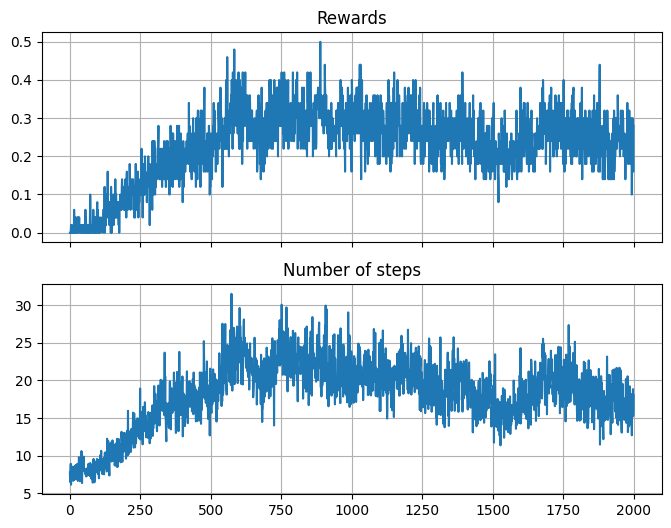

In [ ]:
avg_steps = np.mean(steps, 0)
avg_rewards = np.mean(rewards, 0)

f, axes = plt.subplots(2, sharex=True, figsize=(8, 6))
axes[0].plot(avg_rewards)
axes[0].grid()
axes[0].set_title('Rewards')
axes[1].plot(avg_steps)
axes[1].grid()
axes[1].set_title('Number of steps');

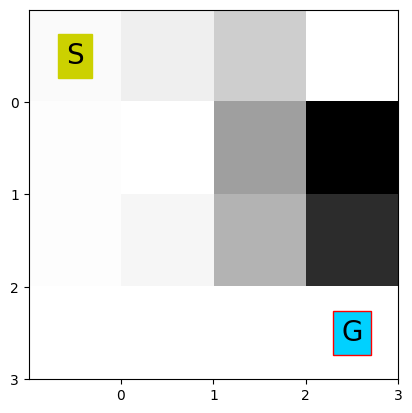

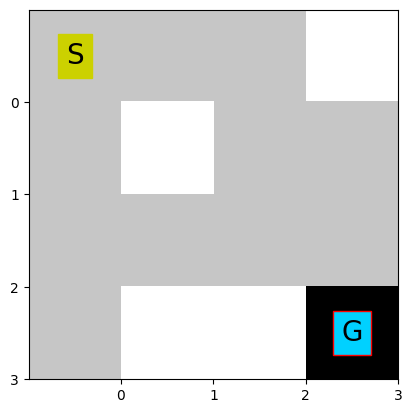

In [ ]:
mean_Q = np.mean(Qs, 0) # Average over all runs 
V = [np.max(q) for q in mean_Q]
plot_matrix(V)
plot_matrix(env_reconstruction+found_rewards);

We can see that the overall number of steps in each episode is significantly reeduced compared to the non-penalized training from above. The overall rewards, however, have also been slightly decreased. With increasing penalty, e.g. $0.001$, the number of steps converges to $6$, corresponding to the shortest possible trajectory but the training becomes a bit more unstable. 

### Bonus track: deterministic game

As bonus testing, we show that the main difficulty of this game is the slippery floor. This provides an uncertainty in the outcome of the actions that makes it harder to estimate the proper Q-values, requiring multiple episodes to train. However, we can choose to play in a deterministic framework by setting `is_slippery=False` in the environment. As shown below, the agents have no difficulty to find the optimal policy in a matter of a few episodes. 

In [ ]:
env = gym.make('FrozenLake-v1', is_slippery=False)

# Set learning rate and discount factor parameters
alpha = 0.8
gamma = 0.9
cost = 0. # Don't even need a penalty

# Runs of the algorithm and episodes of each run
runs = 50
num_episodes = 2000

steps, rewards, Qs = [], [], []
for _ in tqdm(range(runs)):
    Q, time_steps, obtained_rewards = train_q_table(env, num_episodes, alpha, gamma, cost=cost)

    Qs.append(Q)
    steps.append(time_steps)
    rewards.append(obtained_rewards)

100%|██████████| 50/50 [00:08<00:00,  6.15it/s]


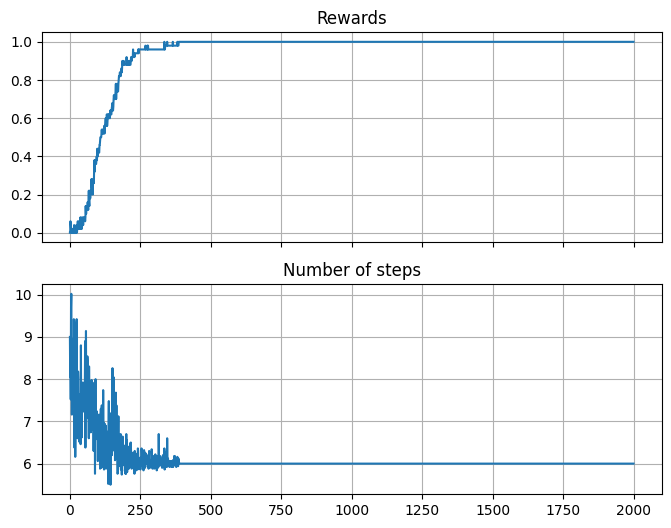

In [ ]:
avg_steps = np.mean(steps, 0)
avg_rewards = np.mean(rewards, 0)

f, axes = plt.subplots(2, sharex=True, figsize=(8, 6))
axes[0].plot(avg_rewards)
axes[0].grid()
axes[0].set_title('Rewards')
axes[1].plot(avg_steps)
axes[1].grid()
axes[1].set_title('Number of steps');

## Cart-pole example

To create the environment, do as previously with the Frozen Lake

In [ ]:
env = gym.make('CartPole-v1')

Now the **state** is a tuple of 4 elements:
- Cart position $\in [-2.4, 2.4]$
- Cart velocity $\in [-\infty, \infty]$
- Pole Angle $\in [-41.8,41.8]$
- Pole Velocity at tip $\in [- \infty, \infty]

To such environment we can do 2 **actions**:
- 0: Push cart to the left
- 1: Push cart to the right

**Reward** is 1 for every step taken, including the termination step

An episode ends (done = 1) if:
- Pole Angle is more than ±12°
- Cart Position is more than ±2.4 (center of the cart reaches the edge of the display)
- Episode length is greater than 200

The game is solved if the average reward is greater than or equal to 195.0 over 100 consecutive trials.

First of all, we have to tweak our training loop a bit and change how we account for the reward.

In [ ]:
def train_q_network(env, agent, num_episodes, batch_size, max_t=201):
    "Train a Q-network based agent in the environment."
    steps, rewards, states = [], [], []
  
    for _ in tqdm(range(num_episodes)):
        # Reset the environment for each new episode
        state = env.reset()[0]
        state = np.reshape(state, [1, state_size])
        done = False
        episode_reward = 0
        
        for j in range(max_t):
        # The Q-Network learning algorithm
            action = agent.act(state)
            next_state, reward, done, _, _ = env.step(action)    
            next_state = np.reshape(next_state, [1, state_size])
            agent.memorize(state, action, reward, next_state, done)
            episode_reward += reward # Accumulated reward over the game
            state = next_state    

            if done:
                steps.append(j)
                break

        rewards.append(episode_reward)
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)
    
    return rewards, steps

In [ ]:
class QNAgent(QNAgent):
    def __init__(self, q_network, n_actions):
        self.model = q_network
        self.action_size = n_actions
        self.memory = deque(maxlen=10000)
        self.gamma = 0.999    # discount rate
        self.epsilon = 1.0    # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001

In [ ]:
# Parameters of the environment
runs = 1 # Watch out! It takes a while, prototype with only one run
num_episodes = 2000

# Parameters for the agent
batch_size = 128

# To get state and action size:
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# Initialize the Q network
q_network = make_q_network(state_size, env.action_space.n)

# We will run the progam runs times to average over many played games
rewards_per_run = []
steps_per_run = []
for runs in range(runs):
    agent = QNAgent(q_network, action_size)
    rewards, steps = train_q_network(env, agent, num_episodes, batch_size)

    rewards_per_run.append(rewards)
    steps_per_run.append(steps)

Now let us define a function to find whether our agent has beaten the game according to the criterion.

In [ ]:
def find_beat(rewards):
    "Finds the episode at which the game has been beaten."
    rewards = np.array(rewards)
    for k in range(100, len(rewards)):
        if (rewards[k-100:k] >= 195).all():
            break
    return k

In [ ]:
beat_episode = find_beat(rewards_per_run[0])
print(f"The game has been beaten in episode {beat_episode}!")

The game has been beaten in episode 1692!


Let's see how the training went :)

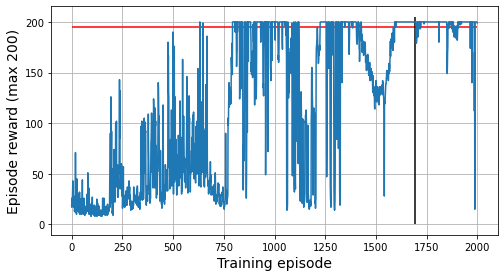

In [ ]:
plt.figure(figsize=(8, 4.2))
plt.plot(np.mean(rewards_per_run, 0))
plt.hlines(195, 0, num_episodes, colors='red')
plt.vlines(beat_episode, 0, 205, colors='black')
plt.grid()
plt.xlabel("Training episode", fontsize=14)
plt.ylabel("Episode reward (max 200)", fontsize=14);

It's not bad! We see that the agent was capable of learning how to balance the pole fairly dencently. Even more, accounting for the fact that the agent is still doing some random actions in this plot. In order to evaluate it properly, we should perform an episode of the game with $\epsilon=0$ to properly assess the performance after every training episode.

However, we can see that the training is a bit unstable and that it has quite some bad episodes even after learing a good policy. In order to improve this, we could implement what is known as [double Q-learning](https://ojs.aaai.org/index.php/AAAI/article/view/10295), which has been shown to improve the learning stability quite a lot. 